<a href="https://colab.research.google.com/github/martinasalis/CoronavirusTweetClassification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from gensim.parsing.preprocessing import remove_stopwords

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
def load_dataset():

    # Load train data
    train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "ISO-8859-1")

    # Load test data
    test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "ISO-8859-1")

    return train, test


In [111]:
train, test = load_dataset()
print(train.count())

num_label_train = train['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()

UserName         41157
ScreenName       41157
Location         32567
TweetAt          41157
OriginalTweet    41157
Sentiment        41157
dtype: int64


**Plot distribution of the classes in train set and test set**

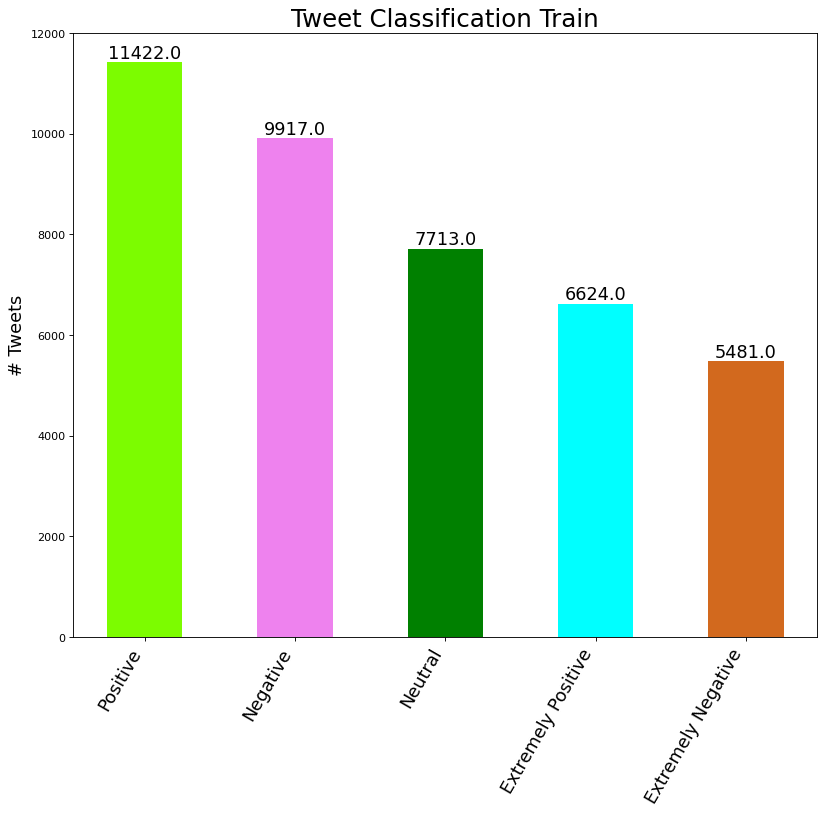

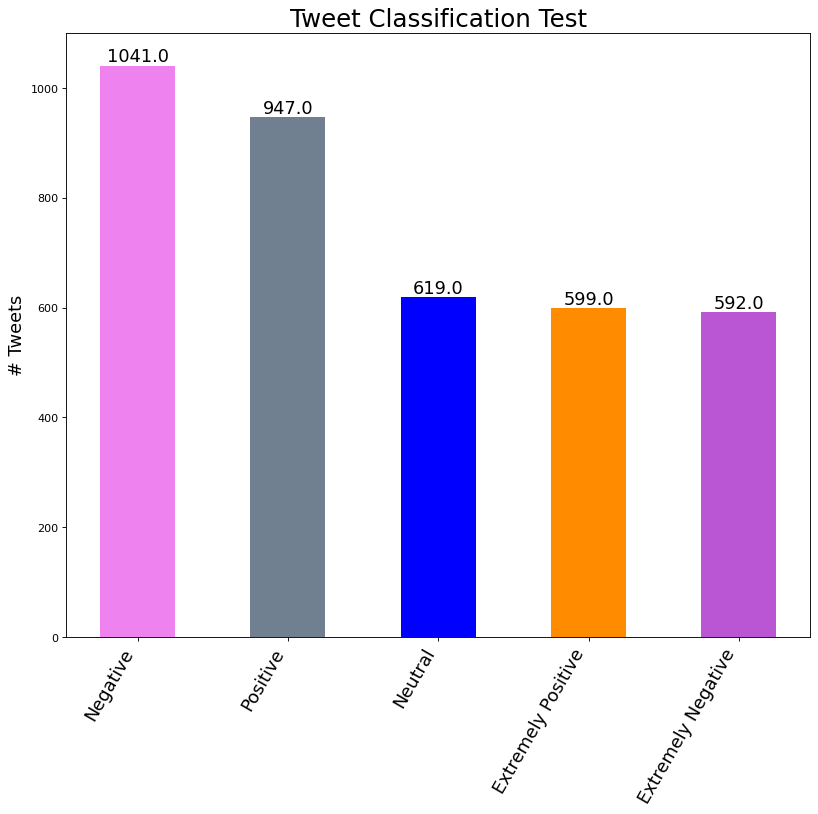

In [112]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 12000)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)


**Plot number of words in the tweets**

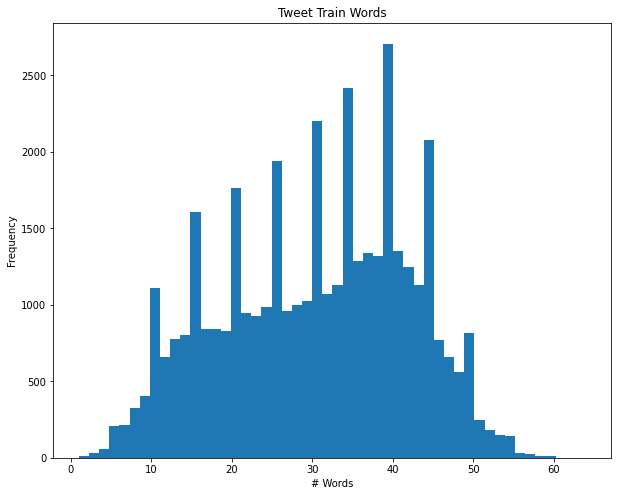

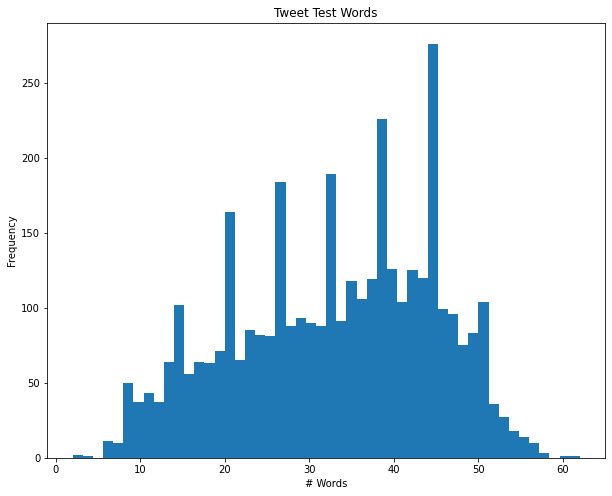

In [113]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()
test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()

**Pre-Processing**

UserName         41131
ScreenName       41131
Location         32550
TweetAt          41131
OriginalTweet    41131
Sentiment        41131
TotalWords       41131
NoURL            41131
NoTag            41131
NoPunct          41131
NoStopWords      41131
Words            41131
dtype: int64


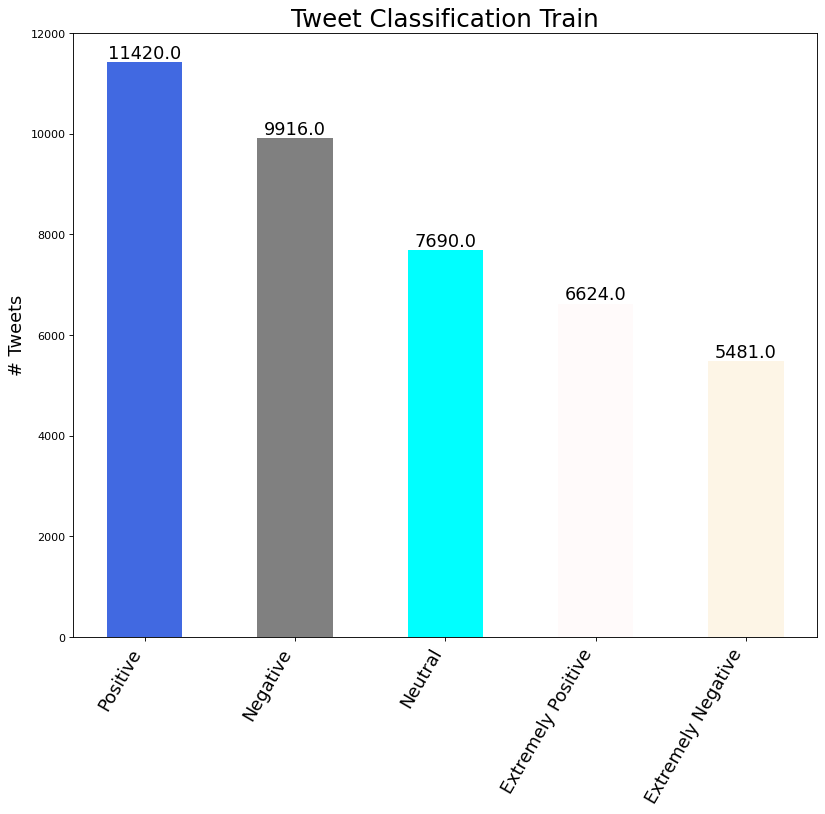

In [122]:
def pre_processing(df):

  # Remove URL from text
  df['NoURL'] = df['OriginalTweet'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove Tag from text
  df['NoTag'] = df['NoURL'].str.replace('@\S+', '', case=False)

  # Remove punctation from text
  df['NoPunct'] = df['NoTag'].str.translate(str.maketrans('', '', string.punctuation))

  return df


def remove_stop_words(df):
  df['NoStopWords'] = df['NoPunct'].apply(lambda x: remove_stopwords(str(x)))
  df['NoStopWords'].replace('', np.nan, inplace=True)
  df.dropna(subset=['NoStopWords'], inplace=True)
  print(df.count())
  return df


train = pre_processing(train)
train = remove_stop_words(train)
train['Words'] = train['NoStopWords'].str.split(' ')

num_label_train = train['Sentiment'].value_counts()
plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 12000)
